In [ ]:
import json
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

LOG_DIR = "/home/aiscuser/train_gen_log"
MAX_STEP = 450
THREADS = 1

REPEATS = 16  # 你说的“一道题正常情况下会有16次input”


def count_bins(by_input: dict[str, list[float]], repeats: int) -> np.ndarray:
    """
    统计每个 input 在本 step 中出现的次数（len(scores)），
    返回长度 repeats+1 的数组，bins[k] = 出现 k 次的 input 个数。
    """
    bins = np.zeros(repeats + 1, dtype=int)
    for scores in by_input.values():
        c = len(scores)
        if c > repeats:  # 若超出16，归到最后一个桶
            c = repeats
        bins[c] += 1
    return bins


def process_step(step: int):
    path = os.path.join(LOG_DIR, f"global_step_{step}.json")
    if not os.path.isfile(path):
        return None

    with open(path, "r") as f:
        log = json.load(f)

    longqa_scores, dis_scores = [], []
    by_input_longqa, by_input_dis = {}, {}

    for pair in log:
        txt = pair["input"].split("<|im_end|>\n<|im_start|>assistant\n")[0].strip()
        is_longqa_candidate = "passage 2:" in txt.lower()
        is_dis = "uuid" in txt.lower()
        if is_longqa_candidate:
            if is_dis:
                dis_scores.append(pair["score"])
                by_input_dis.setdefault(txt, []).append(pair["score"])
            else:
                longqa_scores.append(pair["score"])
                by_input_longqa.setdefault(txt, []).append(pair["score"])

    # 平均分
    longqa_avg = np.mean(longqa_scores) if longqa_scores else np.nan
    dis_avg = np.mean(dis_scores) if dis_scores else np.nan

    # 具有“不同分数”的 input 数量
    var_input_cnt = sum(len(set(s)) > 1 for s in by_input_longqa.values()) + sum(
        len(set(s)) > 1 for s in by_input_dis.values()
    )

    # 出现次数分布（0..16）
    bins_longqa = count_bins(by_input_longqa, REPEATS)
    bins_dis = count_bins(by_input_dis, REPEATS)
    longqa_avg = np.mean(longqa_scores) if longqa_scores else np.nan
    dis_avg = np.mean(dis_scores) if dis_scores else np.nan
    longqa_score_dict = {}
    longqa_dis_score_dict = {}
    for txt in by_input_longqa:
        key = int(round(sum(by_input_longqa[txt])))
        if key not in longqa_score_dict:
            longqa_score_dict[key] = 0
        longqa_score_dict[key] += 1
    for txt in by_input_dis:
        key = int(round(sum(by_input_dis[txt])))
        if key not in longqa_dis_score_dict:
            longqa_dis_score_dict[key] = 0
        longqa_dis_score_dict[key] += 1

    result = {
        "step": step,
        "longqa_avg": longqa_avg,
        "longqa_dis_avg": dis_avg,
        "var_input_cnt": var_input_cnt,
        "bins_longqa": bins_longqa,  # np.array shape (17,)
        "bins_dis": bins_dis,  # np.array shape (17,)
    }
    for key in longqa_score_dict:
        result[f"longqa_score_{key}"] = longqa_score_dict[key]
    for key in longqa_dis_score_dict:
        result[f"longqa_dis_score_{key}"] = longqa_dis_score_dict[key]
    print(f"Processed step {step}:")
    print(result)
    return result


def main():
    # records, missing = [], []
    # with ThreadPoolExecutor(max_workers=THREADS) as pool:
    #     futures = {pool.submit(process_step, s): s for s in range(1, MAX_STEP + 1)}
    #     for fut in tqdm(as_completed(futures), total=MAX_STEP, desc="Parsing logs"):
    #         res = fut.result()
    #         if res:
    #             records.append(res)
    #         else:
    #             missing.append(futures[fut])

    # # --- 基础表 ---
    # base_rows = []
    # long_bins_rows, dis_bins_rows = [], []

    # for r in records:
    #     step = r["step"]
    #     base_rows.append(
    #         {
    #             "step": step,
    #             "longqa_avg": r["longqa_avg"],
    #             "longqa_dis_avg": r["longqa_dis_avg"],
    #             "var_input_cnt": r["var_input_cnt"],
    #         }
    #     )
    #     base_rows[-1].update(
    #         {
    #             f"longqa_score_{k}": r.get(f"longqa_score_{k}", 0)
    #             for k in range(REPEATS + 1)
    #         }
    #     )
    #     base_rows[-1].update(
    #         {
    #             f"longqa_dis_score_{k}": r.get(f"longqa_dis_score_{k}", 0)
    #             for k in range(REPEATS + 1)
    #         }
    #     )

    #     # 展开 bins，列名如 bin_0, bin_1, ..., bin_16
    #     long_bins_rows.append(
    #         {
    #             "step": step,
    #             **{f"bin_{i}": r["bins_longqa"][i] for i in range(REPEATS + 1)},
    #         }
    #     )
    #     dis_bins_rows.append(
    #         {"step": step, **{f"bin_{i}": r["bins_dis"][i] for i in range(REPEATS + 1)}}
    #     )

    # df_base = pd.DataFrame(base_rows).set_index("step").sort_index()
    # df_long_bins = pd.DataFrame(long_bins_rows).set_index("step").sort_index()
    # df_dis_bins = pd.DataFrame(dis_bins_rows).set_index("step").sort_index()

    # # 保存
    # df_base.to_csv("reward_stats.csv")
    # df_long_bins.to_csv("longqa_bins.csv")
    # df_dis_bins.to_csv("longqa_dis_bins.csv")
    # load the saved csv files
    df_base = pd.read_csv("reward_stats.csv", index_col="step")
    df_long_bins = pd.read_csv("longqa_bins.csv", index_col="step")
    df_dis_bins = pd.read_csv("longqa_dis_bins.csv", index_col="step")

    # --- 图1：平均分 ---
    plt.figure()
    plt.plot(df_base.index, df_base["longqa_avg"], label="with KeyChain data")
    plt.plot(df_base.index, df_base["longqa_dis_avg"], label="without KeyChain data")
    plt.xlabel("Global Step")
    plt.ylabel("Average Reward")
    plt.title("Average reward across steps")
    plt.legend()
    plt.tight_layout()
    plt.savefig("reward_avg.pdf")

    # --- 图2：具有不同分数的 input 数量 ---
    plt.figure()
    plt.plot(
        df_base.index, df_base["var_input_cnt"], label="Inputs w/ different scores"
    )
    plt.xlabel("Global Step")
    plt.ylabel("Count")
    plt.title("Inputs with score variance per step")
    plt.legend()
    plt.tight_layout()
    plt.savefig("input_variance.pdf")

    # --- 图3/4：出现次数分布（堆叠面积图）---
    def plot_bins(df_bins, title, fname):
        # df_bins: index=step, columns bin_0..bin_16
        df_bins_sorted = df_bins.sort_index()
        fig, ax = plt.subplots(figsize=(9, 5))
        df_bins_sorted.plot.area(ax=ax)
        plt.xlabel("Global Step")
        plt.ylabel("#Inputs")
        plt.title(title)
        plt.tight_layout()
        plt.savefig(fname)

    plot_bins(
        df_long_bins,
        "LongQA inputs occurrence distribution (0~16/step)",
        "longqa_bins_area.pdf",
    )
    plot_bins(
        df_dis_bins,
        "LongQA-Dis inputs occurrence distribution (0~16/step)",
        "longqa_dis_bins_area.pdf",
    )

    # if missing:
    #     print(f"\n⚠️  跳过 {len(missing)} 个缺失文件，示例: {missing[:10]}")



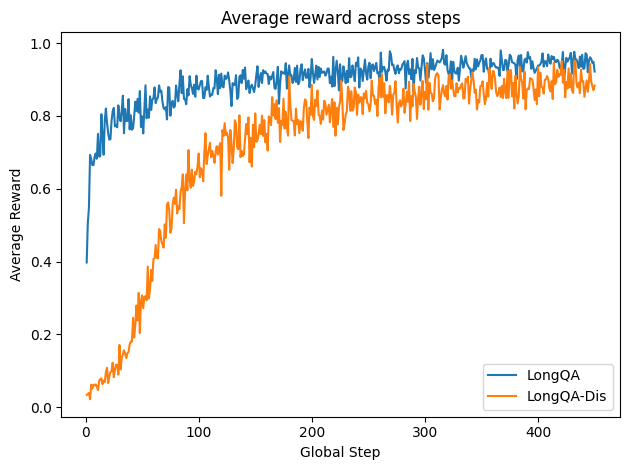

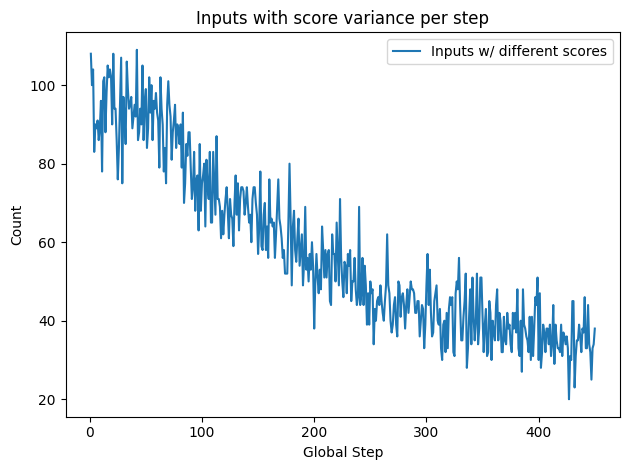

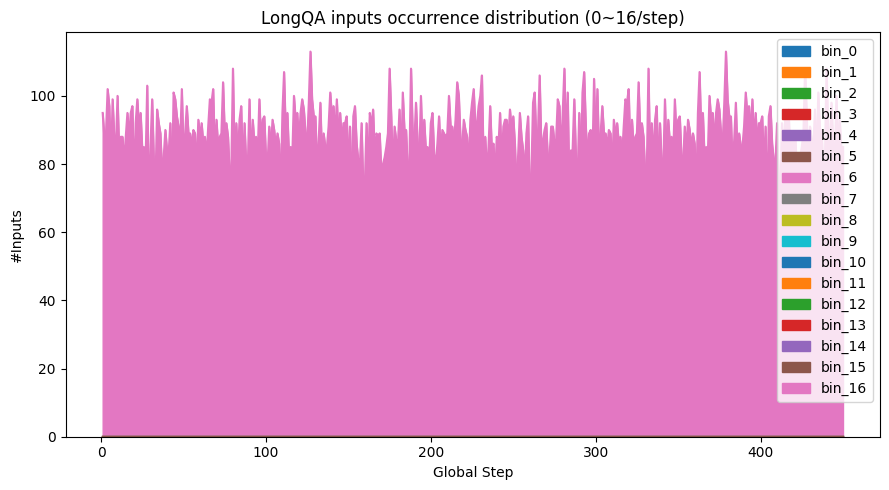

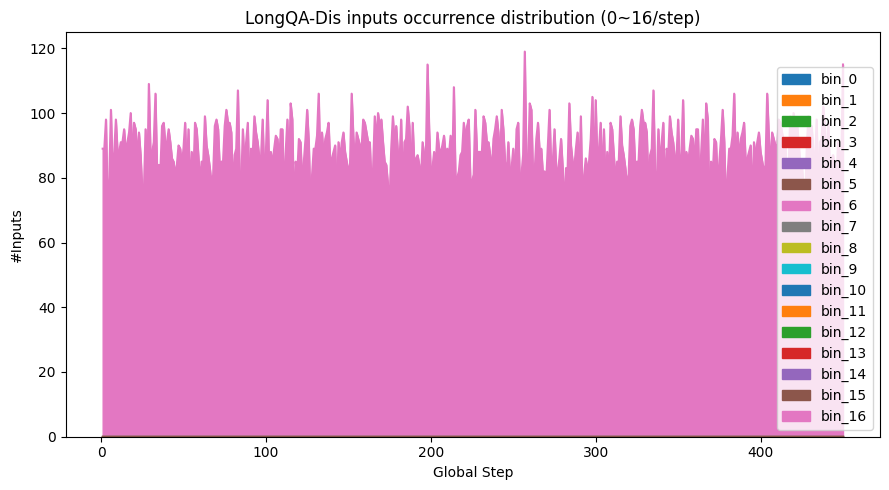

In [2]:
main()